# Minimal Implementation of the Self-RAG Paper
[Read the paper on arXiv](https://arxiv.org/abs/2310.11511)


In [1]:
!pip uninstall -y \
langchain langchain-core langchain-community langchain-experimental \
langchain-chroma langchain-google-genai langchain-huggingface \
langchain-mistralai langchain-ollama langchain-voyageai


Found existing installation: langchain 1.1.3
Uninstalling langchain-1.1.3:
  Successfully uninstalled langchain-1.1.3
Found existing installation: langchain-core 1.2.0
Uninstalling langchain-core-1.2.0:
  Successfully uninstalled langchain-core-1.2.0
Found existing installation: langchain-community 0.4.1
Uninstalling langchain-community-0.4.1:
  Successfully uninstalled langchain-community-0.4.1


## Installing Dependencies

In [2]:
!pip install -q -U \
langgraph \
"langchain[openai]" \
langchain-community \
langchain-text-splitters \
bs4 \
pypdf



[notice] A new release of pip is available: 25.0 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip


## Setup API Keys and Models

In [3]:
import os
import getpass
from langchain_openai import AzureChatOpenAI, AzureOpenAIEmbeddings


def set_env(key: str, default: str | None = None, secret: bool = False) -> None:
    """
    Set an environment variable if it does not already exist.

    - If `default` is provided, it is used directly.
    - If `secret=True` and no default is provided, the user is prompted securely.
    """
    if key in os.environ:
        return

    if default is not None:
        os.environ[key] = default
    elif secret:
        os.environ[key] = getpass.getpass(f"{key}: ")
    else:
        raise ValueError(f"{key} must be set")


set_env(
    "AZURE_OPENAI_ENDPOINT",
    "https://assessment-test-3-found-resource.cognitiveservices.azure.com/",
)

set_env(
    "AZURE_OPENAI_API_KEY",
    secret=True,  
)

set_env(
    "AZURE_OPENAI_API_VERSION",
    "2025-01-01-preview",
)

set_env(
    "AZURE_OPENAI_CHAT_DEPLOYMENT_NAME",
    "gpt-4.1-mini",
)

set_env(
    "AZURE_OPENAI_EMBEDDING_DEPLOYMENT_NAME",
    "text-embedding-ada-002",
)


embedding_model = AzureOpenAIEmbeddings(
    azure_deployment=os.environ["AZURE_OPENAI_EMBEDDING_DEPLOYMENT_NAME"],
    azure_endpoint=os.environ["AZURE_OPENAI_ENDPOINT"],
    openai_api_key=os.environ["AZURE_OPENAI_API_KEY"],
    openai_api_version="2023-05-15",  # embeddings often lag behind chat versions
)

response_model = AzureChatOpenAI(
    azure_deployment=os.environ["AZURE_OPENAI_CHAT_DEPLOYMENT_NAME"],
    azure_endpoint=os.environ["AZURE_OPENAI_ENDPOINT"],
    openai_api_key=os.environ["AZURE_OPENAI_API_KEY"],
    openai_api_version=os.environ["AZURE_OPENAI_API_VERSION"],
    temperature=0,
)

grader_model = AzureChatOpenAI(
    azure_deployment=os.environ["AZURE_OPENAI_CHAT_DEPLOYMENT_NAME"],
    azure_endpoint=os.environ["AZURE_OPENAI_ENDPOINT"],
    openai_api_key=os.environ["AZURE_OPENAI_API_KEY"],
    openai_api_version=os.environ["AZURE_OPENAI_API_VERSION"],
    temperature=0,
)

/home/shohog/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


AZURE_OPENAI_API_KEY:  ········


## Chunking

In [4]:
# 1. Change the import to the PDF loader
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter


PDF_FILE_PATH = "constitution_bd.pdf" 


# Instantiate the PDF loader
loader = PyPDFLoader(PDF_FILE_PATH)

# Load the documents (each page of the PDF becomes a separate Document object)
docs = loader.load() 


text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100, 
    chunk_overlap=50
)

# Split the documents (pages) into smaller chunks
doc_splits = text_splitter.split_documents(docs)

doc_splits[1].page_content.strip()

'PART I\nTHE REPUBLIC\nThe Constitution of the People   ’s Republic of Bangladesh\n( ACT NO. OF 1972 )\n[BISMILLAH-AR-RAHMAN-AR-RAHIM1\n (In the name of Allah, the Beneficient, the Merciful)/\n In the name of the Creator, the Merciful.]\n  PREAMBLE'

## Retriever

In [5]:
# --- LangChain Implementation ---
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_openai import AzureOpenAIEmbeddings 

# 2. Use the configured embedding model
vectorstore = InMemoryVectorStore.from_documents(
    documents=doc_splits, 
    embedding=embedding_model
)

retriever = vectorstore.as_retriever()

## Building Tools

In [6]:
from langchain.tools import tool

@tool
def retrieve_from_resume(query: str) -> str:
    """Search and return the most relevant information from the Constitution of Bangladesh using a retriever."""
    docs = retriever.invoke(query)
    return "\n\n".join([doc.page_content for doc in docs])

retriever_tool = retrieve_from_resume

retriever_tool.invoke({"query": "What is the preamble of the Constitution about?"})

'FUNDAMENTAL PRINCIPLES OF STATE POLICY\nBasic\nprovisions\nof the\nConstitution\nare not\namendable\n7B. Notwithstanding anything contained in article 142 of the Constitution, the\npreamble, all articles of Part I, all articles of Part II, subject to the provisions\nof Part IXA all articles of Part III, and the provisions of articles relating to the\n\nof the\nConstitution\n7. (1) All powers in the Republic belong to the people, and their exercise on\nbehalf of the people shall be effected only under, and by the authority of, this\nConstitution.\n    (2) This Constitution is, as the solemn expression of the will of the people,\nthe supreme law of the Republic, and if any other law is inconsistent with this\n\nPART I\nTHE REPUBLIC\nThe Constitution of the People   ’s Republic of Bangladesh\n( ACT NO. OF 1972 )\n[BISMILLAH-AR-RAHMAN-AR-RAHIM1\n (In the name of Allah, the Beneficient, the Merciful)/\n In the name of the Creator, the Merciful.]\n  PREAMBLE\n\npreamble, all articles of Par

In [7]:
from langgraph.graph import MessagesState
from langchain.chat_models import init_chat_model

from langchain_openai import AzureChatOpenAI


def generate_query_or_respond(state: MessagesState):
    """Call the model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply respond to the user.
    """
    response = (
        response_model
        .bind_tools([retriever_tool]).invoke(state["messages"])  
    )
    return {"messages": [response]}

In [8]:
from pydantic import BaseModel, Field
from typing import Literal

GRADE_PROMPT = (
    "You are a grader assessing relevance of a retrieved document to a user question. \n "
    "Here is the retrieved document: \n\n {context} \n\n"
    "Here is the user question: {question} \n"
    "If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n"
    "Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."
)


class GradeDocuments(BaseModel):  
    """Grade documents using a binary score for relevance check."""

    binary_score: str = Field(
        description="Relevance score: 'yes' if relevant, or 'no' if not relevant"
    )



def grade_documents(
    state: MessagesState,
) -> Literal["generate_answer", "rewrite_question"]:
    """Determine whether the retrieved documents are relevant to the question."""
    question = state["messages"][0].content
    context = state["messages"][-1].content

    prompt = GRADE_PROMPT.format(question=question, context=context)
    response = (
        grader_model
        .with_structured_output(GradeDocuments).invoke(  
            [{"role": "user", "content": prompt}]
        )
    )
    score = response.binary_score

    if score == "yes":
        return "generate_answer"
    else:
        return "rewrite_question"

In [9]:
from langchain.messages import HumanMessage

REWRITE_PROMPT = (
    "Look at the input and try to reason about the underlying semantic intent / meaning.\n"
    "Here is the initial question:"
    "\n ------- \n"
    "{question}"
    "\n ------- \n"
    "Formulate an improved question:"
)


def rewrite_question(state: MessagesState):
    """Rewrite the original user question."""
    messages = state["messages"]
    question = messages[0].content
    prompt = REWRITE_PROMPT.format(question=question)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [HumanMessage(content=response.content)]}

In [10]:
GENERATE_PROMPT = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer the question. "
    "If you don't know the answer, just say that you don't know. "
    "Use three sentences maximum and keep the answer concise.\n"
    "Question: {question} \n"
    "Context: {context}"
)


def generate_answer(state: MessagesState):
    """Generate an answer."""
    question = state["messages"][0].content
    context = state["messages"][-1].content
    prompt = GENERATE_PROMPT.format(question=question, context=context)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [response]}

## Building the Graph

In [11]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

workflow = StateGraph(MessagesState)

# Define the nodes we will cycle between
workflow.add_node(generate_query_or_respond)
workflow.add_node("retrieve", ToolNode([retriever_tool]))
workflow.add_node(rewrite_question)
workflow.add_node(generate_answer)

workflow.add_edge(START, "generate_query_or_respond")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "generate_query_or_respond",
    # Assess LLM decision (call `retriever_tool` tool or respond to the user)
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate_answer", END)
workflow.add_edge("rewrite_question", "generate_query_or_respond")

# Compile
graph = workflow.compile()

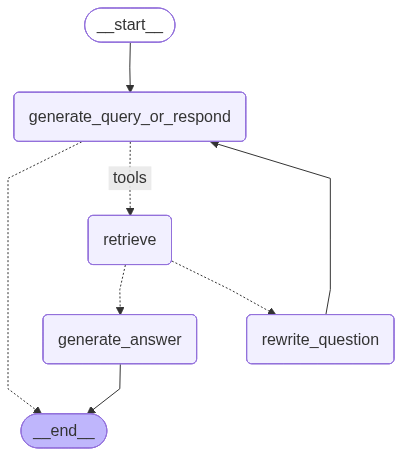

In [12]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
for chunk in graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "What is the preamble of the Constitution about?",
            }
        ]
    }
):
    for node, update in chunk.items():
        print("Update from node", node)
        update["messages"][-1].pretty_print()
        print("\n\n")

Update from node generate_query_or_respond
================================== Ai Message ==================================
Tool Calls:
  retrieve_from_resume (call_DftHAcY4psLAya1t4hNgVTwP)
 Call ID: call_DftHAcY4psLAya1t4hNgVTwP
  Args:
    query: preamble of the Constitution



Update from node retrieve
================================= Tool Message =================================
Name: retrieve_from_resume

FUNDAMENTAL PRINCIPLES OF STATE POLICY
Basic
provisions
of the
Constitution
are not
amendable
7B. Notwithstanding anything contained in article 142 of the Constitution, the
preamble, all articles of Part I, all articles of Part II, subject to the provisions
of Part IXA all articles of Part III, and the provisions of articles relating to the

PART I
THE REPUBLIC
The Constitution of the People   ’s Republic of Bangladesh
( ACT NO. OF 1972 )
[BISMILLAH-AR-RAHMAN-AR-RAHIM1
 (In the name of Allah, the Beneficient, the Merciful)/
 In the name of the Creator, the Merciful.]
  PREAMBL

In [ ]:
import builtins

def cli_chat(graph):
    print("Type 'exit' or 'quit' to stop.\n")

    while True:
        user_input = builtins.input("You: ").strip()
        if user_input.lower() in {"exit", "quit"}:
            break

        for chunk in graph.stream(
            {"messages": [{"role": "user", "content": user_input}]}
        ):
            for _, update in chunk.items():
                update["messages"][-1].pretty_print()
                print()

cli_chat(graph)

Type 'exit' or 'quit' to stop.



You:  give me the summary of the constitution


================================== Ai Message ==================================
Tool Calls:
  retrieve_from_resume (call_UP9QL8qzTZBSXRzc0LDhX7Z2)
 Call ID: call_UP9QL8qzTZBSXRzc0LDhX7Z2
  Args:
    query: summary of the constitution of Bangladesh

================================= Tool Message =================================
Name: retrieve_from_resume

PART I
THE REPUBLIC
The Constitution of the People   ’s Republic of Bangladesh
( ACT NO. OF 1972 )
[BISMILLAH-AR-RAHMAN-AR-RAHIM1
 (In the name of Allah, the Beneficient, the Merciful)/
 In the name of the Creator, the Merciful.]
  PREAMBLE

bdlaws.minlaw.gov.bd/act-print-367.html 1/74
12/09/2021 The Constitution of the People   ’s Republic of Bangladesh
PART I
THE REPUBLIC
The Constitution of the People   ’s Republic of Bangladesh
( ACT NO. OF 1972 )
[BISMILLAH-AR-RAHMAN-AR-RAHIM1

fourth day of November, 1972 A.D., do hereby adopt, enact and give to ourselves this
Constitution.
 
2
3
The
Republic 1. Bangladesh is a unitary, indepen

You:  what are the preambels


================================== Ai Message ==================================
Tool Calls:
  retrieve_from_resume (call_NDMSXQMnNQIbMFM09ZS43FcU)
 Call ID: call_NDMSXQMnNQIbMFM09ZS43FcU
  Args:
    query: preambles

================================= Tool Message =================================
Name: retrieve_from_resume

FUNDAMENTAL PRINCIPLES OF STATE POLICY
Basic
provisions
of the
Constitution
are not
amendable
7B. Notwithstanding anything contained in article 142 of the Constitution, the
preamble, all articles of Part I, all articles of Part II, subject to the provisions
of Part IXA all articles of Part III, and the provisions of articles relating to the

preamble, all articles of Part I, all articles of Part II, subject to the provisions
of Part IXA all articles of Part III, and the provisions of articles relating to the
basic structures of the Constitution including article 150 of Part XI shall not
be amendable by way of insertion, modification, substitution, repeal or by any
